In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

#make plots inline using jupyter magic
%matplotlib inline

import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn import datasets, linear_model, metrics


import matplotlib as mpl
import seaborn as sns

import sklearn.linear_model as skl_lm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.neighbors import KNeighborsClassifier
#Balanced RF Classifier
from imblearn.ensemble import BalancedRandomForestClassifier as BRF

from IPython.display import Markdown as md  #enable markdown within code cell
from IPython.display import display, Math, Latex

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import confusion_matrix
import time
import random
import scipy

from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, precision_recall_curve, make_scorer,f1_score
from sklearn.metrics import precision_recall_curve as PRC

## Homemade code imports
import metrics

data_dir = '/run/media/mnewlin/_userdata/uhnds/'
original_netflow_data_dir = data_dir + 'network/extracted/'
original_netflow_file = 'netflow_day-02'
fake_dir = '/run/media/mnewlin/_userdata/uhnds/network/converted/fake/'
real_dir = '/run/media/mnewlin/_userdata/uhnds/network/converted/real/'
real_file = 'netflow_day-02'

In [2]:
"""
    Function to read in a single real sample from a given directory based
    on the desired length of the sample.
"""
def load_real_sample(sample_num, sample_length=100):

    data_dir = 'samples_{}/'.format(sample_length)
    if sample_length < 10000:
        if sample_num >= 10000:
            return -1
    elif sample_length < 100000:
        if sample_num >= 2000:
            return -1
    else:
        if sample_num >= 2000:
            return -1
        
    load_file = real_file + '_sample_{}.txt'.format(sample_num)
    filename = real_dir + data_dir + load_file
    df = pd.read_csv(filename, names=['Duration', 'SrcDevice', 
            'DstDevice', 'Protocol', 'SrcPort', 'DstPort', 'SrcPackets', 'DstPackets', 
            'SrcBytes', 'DstBytes'], sep=' ', dtype=np.int64)
    return df

In [3]:
"""
    Function to read in a single fake sample from a given directory based
    on the desired length of the sample.
"""
def load_fake_sample(sample_num, sample_length=100):
    data_dir = 'samples_{}/'.format(sample_length)
    if sample_length < 10000:
        if sample_num >= 10000:
            return -1
    elif sample_length < 100000:
        if sample_num >= 2000:
            return -1
    else:
        if sample_num >= 2000:
            return -1

    load_file = real_file + '_random_sample_{}.txt'.format(sample_num)
    filename = fake_dir + data_dir + load_file
    df = pd.read_csv(filename, names=['Duration', 'SrcDevice', 
            'DstDevice', 'Protocol', 'SrcPort', 'DstPort', 'SrcPackets', 'DstPackets', 
            'SrcBytes', 'DstBytes'], sep=' ', dtype=np.int64)
    return df

In [4]:
def load_n_samples(real=True, sample_length=100, num_samples=100, random_state=69):
    data = pd.DataFrame()
    sample_range = 0
    if sample_length <= 1000:
        sample_range = 10000
    elif sample_length <= 10000:
        sample_range = 2000
    elif sample_length <= 100000:
        sample_range = 1160
        
    random.seed(a=random_state)
    sample_list = random.sample(range(sample_range), num_samples)
    if real:
        for num in sample_list:
            data = data.append(load_real_sample(sample_length=sample_length, sample_num=num))
    else:
        for num in sample_list:
            data = data.append(load_fake_sample(sample_length=sample_length, sample_num=num))
    return data

In [5]:
def create_sample_mix(ratio, sample_length=100, num_samples=100, random_state=69):
    real = load_n_samples(real=True, sample_length=sample_length, num_samples=num_samples, random_state=random_state)
    fake = load_n_samples(real=False, sample_length=sample_length, num_samples=num_samples, random_state=random_state)
    real_samples = real.sample(frac=1-ratio, random_state=random_state)
    fake_samples = real.sample(frac=ratio, random_state=random_state)
    samples = real_samples.append(fake_samples)
    return samples

In [6]:
real_samples = load_n_samples(real=True, sample_length=100,num_samples=100, random_state=42)
display(real_samples.describe())

,Duration,SrcDevice,DstDevice,Protocol,SrcPort,DstPort,SrcPackets,DstPackets,SrcBytes,DstBytes
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04
mean,1.119461e+06,488377.297300,441563.229400,11.209600,36232.256500,18326.960500,7.944732e+04,3.166006e+04,5.382791e+07,2.372240e+07
std,1.611235e+06,294756.769115,260218.209268,6.388877,26907.477769,26283.816714,2.470712e+05,4.716046e+05,1.616324e+08,5.917398e+08
min,0.000000e+00,244.000000,1050.000000,1.000000,15.000000,21.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.295400e+04,229715.000000,211700.000000,6.000000,15379.000000,445.000000,2.577500e+02,0.000000e+00,2.732400e+04,0.000000e+00
50%,4.564080e+05,469322.000000,392659.000000,17.000000,34568.000000,5060.000000,8.267500e+03,0.000000e+00,1.785283e+06,0.000000e+00
75%,1.475056e+06,742377.000000,607982.000000,17.000000,51893.500000,41101.000000,5.033300e+04,3.162500e+02,2.060882e+07,2.283900e+04
max,7.654872e+06,999856.000000,999949.000000,17.000000,99992.000000,99924.000000,7.473493e+06,1.883259e+07,4.990079e+09,2.611989e+10


In [7]:
real_samples_2 = load_n_samples(real=True, sample_length=100,num_samples=100, random_state=333)

In [8]:
#fake_samples = load_n_samples(real=False, sample_length=100,num_samples=10)
#display(fake_samples.describe())

In [9]:
#mix_samples = create_sample_mix(ratio=0.1, sample_length=100, num_samples=100)
#display(fake_samples.describe())

## Test Discriminative Behavior

### Sample length 100 - 100 samples

In [29]:
Sr1 = np.sqrt(np.abs(np.nan_to_num(np.array(real_samples).astype(np.int64))))
Sr2 = np.sqrt(np.abs(np.nan_to_num(np.array(real_samples_2).astype(np.int64))))

num_cols = Sr1.shape[1]
sample_length = 100
num_samples = 100
# Reshape into 3d array
Sr1 = np.reshape(Sr1, (num_samples, sample_length, num_cols))
Sr2 = np.reshape(Sr2, (num_samples, sample_length, num_cols))

d0_lp = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.75, r=0.75)
d0_cosine = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='cosine')
d0_mah = metrics.score_set(Sr2,Sr1, sample_length=sample_length, num_samples=num_samples, metric='mahalanobis')
d0_chi = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='chi_squared')
d0_wass = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='wasserstein')
d0_fid = metrics.score_set(Sr1, Sr2, sample_length=sample_length, num_samples=num_samples, metric='fid')
d0_ent = metrics.score_set(Sr1, Sr2, sample_length=sample_length, num_samples=num_samples, metric='entropy')
d0_perp = metrics.score_set(Sr1, Sr2, sample_length=sample_length, num_samples=num_samples, metric='perplexity')


In [30]:
alphagrid = np.arange(0.05,1,step=0.05)
#alphagrid = np.array([0.1])
lp_scores = np.array([])
cosine_scores = np.array([])
mah_scores = np.array([])
chi_scores = np.array([])
wass_scores = np.array([])
fid_scores = np.array([])
ent_scores = np.array([])
perp_scores = np.array([])
for alpha in alphagrid:
    Sg_t = np.sqrt(np.abs(np.nan_to_num(np.array(create_sample_mix(ratio=alpha, sample_length=100, num_samples = 100, random_state=88)))))
    Sg_t = np.reshape(Sg_t, (num_samples, sample_length, num_cols))
    d_lp = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.75, r=0.75)
    d_cosine = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='cosine')
    d_mah = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='mahalanobis')
    d_chi = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='chi_squared')
    d_wass = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='wasserstein')
    d_fid = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='fid')
    d_ent = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='entropy')
    d_perp = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='perplexity')
    lp_scores = np.append(lp_scores, d_lp)
    cosine_scores = np.append(cosine_scores, d_cosine)
    chi_scores = np.append(chi_scores, d_chi)
    mah_scores = np.append(mah_scores, d_mah)
    wass_scores = np.append(wass_scores, d_wass)
    fid_scores = np.append(fid_scores, d_fid)
    ent_scores = np.append(ent_scores, d_ent)
    perp_scores = np.append(perp_scores, d_perp)
    
    print(alpha)

0.05
0.1
0.15000000000000002
0.2
0.25
0.3
0.35000000000000003
0.4
0.45
0.5
0.55
0.6000000000000001
0.6500000000000001
0.7000000000000001
0.7500000000000001
0.8
0.8500000000000001
0.9000000000000001
0.9500000000000001


In [31]:
normalized_lp = 1-lp_scores/d0_lp
normalized_cosine = 1-cosine_scores/d0_cosine
normalized_mah = 1 - mah_scores/d0_mah
normalized_chi = 1-chi_scores/d0_chi
normalized_wass = 1-wass_scores/d0_wass
normalized_fid = 1 - fid_scores/d0_fid
normalized_ent = 1 - ent_scores/d0_ent
normalized_perp = 1 - perp_scores/d0_perp

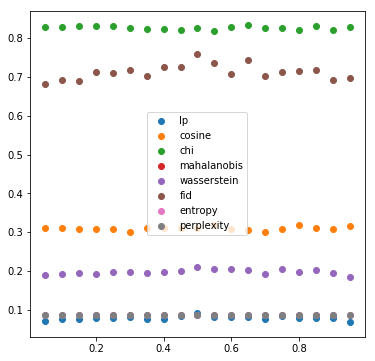

In [32]:

fig = plt.figure(figsize=(6,6))
plt.plot(alphagrid, np.abs(normalized_lp), 'o', label='lp')
plt.plot(alphagrid, np.abs(normalized_cosine), 'o', label='cosine')
plt.plot(alphagrid, np.abs(normalized_chi), 'o', label='chi')
plt.plot(alphagrid, np.abs(normalized_mah), 'o', label='mahalanobis')
plt.plot(alphagrid, np.abs(normalized_wass), 'o', label='wasserstein')
plt.plot(alphagrid, np.abs(normalized_fid), 'o', label='fid')
plt.plot(alphagrid, np.abs(normalized_ent), 'o', label='entropy')
plt.plot(alphagrid, np.abs(normalized_perp), 'o', label='perplexity')
plt.legend()
plt.show()


In [27]:
print(mah_scores)
print(d0_mah)

#print(alphagrid)
#print(scores)
#combined = zip(alphagrid, scores)
#print(list(combined))

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan]
nan


## Test Discriminative Behavior on sample length 1000 - 100 Samples

In [16]:
real_samples = load_n_samples(real=True, sample_length=1000,num_samples=100, random_state=42)
real_samples_2 = load_n_samples(real=True, sample_length=1000,num_samples=100, random_state=333)

In [17]:
Sr1 = np.array(real_samples)
Sr2 = np.array(real_samples_2)
num_cols = Sr1.shape[1]
sample_length = 1000
num_samples = 100
# Reshape into 3d array
Sr1 = np.reshape(Sr1, (num_samples, sample_length, num_cols))
Sr2 = np.reshape(Sr2, (num_samples, sample_length, num_cols))



d0_lp = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.75, r=0.75)
d0_cosine = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='cosine')
#d0_mah = metrics.score_set(Sr2,Sr1, sample_length=sample_length, num_samples=num_samples, metric='mahalanobis')
d0_chi = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='chi_squared')
d0_wass = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='wasserstein')
d0_fid = metrics.score_set(Sr1, Sr2, sample_length=sample_length, num_samples=num_samples, metric='fid')
d0_ent = metrics.score_set(Sr1, Sr2, sample_length=sample_length, num_samples=num_samples, metric='entropy')
d0_perp = metrics.score_set(Sr1, Sr2, sample_length=sample_length, num_samples=num_samples, metric='perplexity')

In [18]:
alphagrid = np.arange(0.05,1,step=0.05)
#alphagrid = np.array([0.1])
lp_scores = np.array([])
cosine_scores = np.array([])
mah_scores = np.array([])
chi_scores = np.array([])
wass_scores = np.array([])
fid_scores = np.array([])
ent_scores = np.array([])
perp_scores = np.array([])
for alpha in alphagrid:
    Sg_t = np.array(create_sample_mix(ratio=alpha, sample_length=1000, num_samples = 100, random_state=88))
    Sg_t = np.reshape(Sg_t, (num_samples, sample_length, num_cols))
    d_lp = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.75, r=0.75)
    d_cosine = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='cosine')
    d_chi = metrics.score_set(Sr1, Sg_t, sample_length=sample_length, num_samples=num_samples, metric='chi_squared')
    d_wass = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='wasserstein')
    d_fid = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='fid')
    d_ent = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='entropy')
    d_perp = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='perplexity')
    lp_scores = np.append(lp_scores, d_lp)
    cosine_scores = np.append(cosine_scores, d_cosine)
    chi_scores = np.append(chi_scores, d_chi)
    wass_scores = np.append(wass_scores, d_wass)
    fid_scores = np.append(fid_scores, d_fid)
    ent_scores = np.append(ent_scores, d_ent)
    perp_scores = np.append(perp_scores, d_perp)
    
    print(alpha)

0.05
0.1
0.15000000000000002
0.2
0.25
0.3
0.35000000000000003
0.4
0.45
0.5
0.55
0.6000000000000001
0.6500000000000001
0.7000000000000001
0.7500000000000001
0.8
0.8500000000000001
0.9000000000000001
0.9500000000000001


In [19]:
normalized_lp = 1-lp_scores/d0_lp
normalized_cosine = 1-cosine_scores/d0_cosine
#normalized_mah = 1 - mah_scores/d0_mah
normalized_chi = 1-chi_scores/d0_chi
normalized_wass = 1-wass_scores/d0_wass
normalized_fid = 1 - fid_scores/d0_fid
normalized_ent = 1 - ent_scores/d0_ent
normalized_perp = 1 - perp_scores/d0_perp

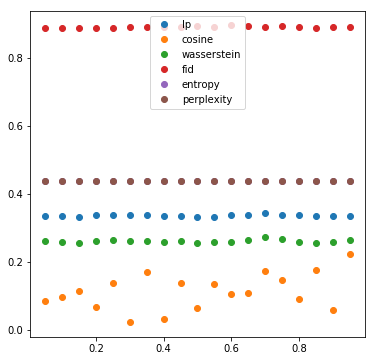

In [21]:
fig = plt.figure(figsize=(6,6))
plt.plot(alphagrid, np.abs(normalized_lp), 'o', label='lp')
plt.plot(alphagrid, np.abs(normalized_cosine), 'o', label='cosine')
#plt.plot(alphagrid, np.abs(normalized_chi), 'o', label='chi')
#plt.plot(alphagrid, np.abs(normalized_mah), 'o', label='mahalanobis')
plt.plot(alphagrid, np.abs(normalized_wass), 'o', label='wasserstein')
plt.plot(alphagrid, np.abs(normalized_fid), 'o', label='fid')
plt.plot(alphagrid, np.abs(normalized_ent), 'o', label='entropy')
plt.plot(alphagrid, np.abs(normalized_perp), 'o', label='perplexity')
plt.legend()
plt.show()

## Test Discriminative Behavior on sample length 1000 with 1000 samples

In [22]:
real_samples = load_n_samples(real=True, sample_length=1000,num_samples=1000, random_state=42)
real_samples_2 = load_n_samples(real=True, sample_length=1000,num_samples=1000, random_state=333)

In [23]:
Sr1 = np.array(real_samples)
Sr2 = np.array(real_samples_2)
num_cols = Sr1.shape[1]
sample_length = 1000
num_samples = 1000
# Reshape into 3d array
Sr1 = np.reshape(Sr1, (num_samples, sample_length, num_cols))
Sr2 = np.reshape(Sr2, (num_samples, sample_length, num_cols))



d0_lp = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.75, r=0.75)
d0_cosine = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='cosine')
#d0_mah = metrics.score_set(Sr2,Sr1, sample_length=sample_length, num_samples=num_samples, metric='mahalanobis')
d0_chi = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='chi_squared')
d0_wass = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='wasserstein')
d0_fid = metrics.score_set(Sr1, Sr2, sample_length=sample_length, num_samples=num_samples, metric='fid')
d0_ent = metrics.score_set(Sr1, Sr2, sample_length=sample_length, num_samples=num_samples, metric='entropy')
d0_perp = metrics.score_set(Sr1, Sr2, sample_length=sample_length, num_samples=num_samples, metric='perplexity')

/home/mnewlin/anaconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:698: RuntimeWarning: invalid value encountered in sqrt
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [24]:
alphagrid = np.arange(0.05,1,step=0.05)
#alphagrid = np.array([0.1])
lp_scores = np.array([])
cosine_scores = np.array([])
mah_scores = np.array([])
chi_scores = np.array([])
wass_scores = np.array([])
fid_scores = np.array([])
ent_scores = np.array([])
perp_scores = np.array([])
for alpha in alphagrid:
    Sg_t = np.array(create_sample_mix(ratio=alpha, sample_length=1000, num_samples = 1000, random_state=88))
    Sg_t = np.reshape(Sg_t, (num_samples, sample_length, num_cols))
    d_lp = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.75, r=0.75)
    d_cosine = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='cosine')
    d_chi = metrics.score_set(Sr1, Sg_t, sample_length=sample_length, num_samples=num_samples, metric='chi_squared')
    d_wass = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='wasserstein')
    d_fid = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='fid')
    d_ent = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='entropy')
    d_perp = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='perplexity')
    lp_scores = np.append(lp_scores, d_lp)
    cosine_scores = np.append(cosine_scores, d_cosine)
    chi_scores = np.append(chi_scores, d_chi)
    wass_scores = np.append(wass_scores, d_wass)
    fid_scores = np.append(fid_scores, d_fid)
    ent_scores = np.append(ent_scores, d_ent)
    perp_scores = np.append(perp_scores, d_perp)
    
    print(alpha)

0.05
0.1
0.15000000000000002
0.2
0.25
0.3
0.35000000000000003
0.4
0.45
0.5
0.55
0.6000000000000001
0.6500000000000001
0.7000000000000001
0.7500000000000001
0.8
0.8500000000000001
0.9000000000000001
0.9500000000000001


In [25]:
normalized_lp = 1-lp_scores/d0_lp
normalized_cosine = 1-cosine_scores/d0_cosine
#normalized_mah = 1 - mah_scores/d0_mah
normalized_chi = 1-chi_scores/d0_chi
normalized_wass = 1-wass_scores/d0_wass
normalized_fid = 1 - fid_scores/d0_fid
normalized_ent = 1 - ent_scores/d0_ent
normalized_perp = 1 - perp_scores/d0_perp

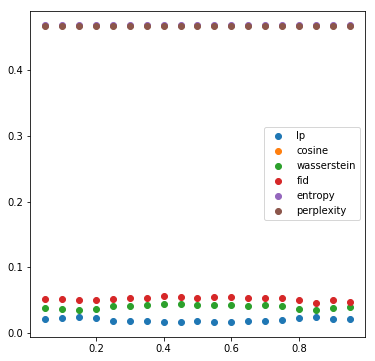

In [28]:
fig = plt.figure(figsize=(6,6))
plt.plot(alphagrid, np.abs(normalized_lp), 'o', label='lp')
plt.plot(alphagrid, np.abs(normalized_cosine), 'o', label='cosine')
#plt.plot(alphagrid, np.abs(normalized_chi), 'o', label='chi')
#plt.plot(alphagrid, np.abs(normalized_mah), 'o', label='mahalanobis')
plt.plot(alphagrid, np.abs(normalized_wass), 'o', label='wasserstein')
plt.plot(alphagrid, np.abs(normalized_fid), 'o', label='fid')
plt.plot(alphagrid, np.abs(normalized_ent), 'o', label='entropy')
plt.plot(alphagrid, np.abs(normalized_perp), 'o', label='perplexity')
plt.legend()
plt.show()